In [1]:
import pandas as pd

In [2]:
df1 = pd.read_csv(r"D:\临床数据\NHANES数据清洗\3年心因死亡数据.csv", low_memory=False)

In [4]:
selected_columns = [
    "SEQN","Doctor told you have diabetes", "Education Level - Adults 20+", "Ever told you had a stroke",
    "Ever told you had coronary heart disease", "Ever told you had high blood pressure",
    "Had at least 12 alcohol drinks/1 yr?", "Marital Status", "Moderate recreational activities",
    "Moderate work activity", "Race", "Smoked at least 100 cigarettes in life", 
    "Vigorous recreational activities", "Vigorous work activity", "Walk or bicycle", "Age", 
    "Minutes sedentary activity", "Ratio of family income to poverty", "Waist Circumference (cm)", 
    "Alanine Aminotransferase (ALT) (U/L)", "Albumin (g/L)", "Albumin_urine (mg/L)", 
    "Alkaline Phosphatase (ALP) (IU/L)", "Bicarbonate (mmol/L)", "Blood urea nitrogen (mmol/L)", 
    "Chloride (mmol/L)", "Cholesterol (mmol/L)", "Creatinine (umol/L)", "Creatinine_urine (umol/L)", 
    "Direct HDL-Cholesterol (mmol/L)", "Gamma Glutamyl Transferase (GGT) (U/L)", "Globulin (g/L)", 
    "Glucose_serum (mmol/L)", "Glycohemoglobin (%)", "Hematocrit (%)", "Hemoglobin (g/dL)", 
    "Iron_refigerated (umol/L)", "Lactate Dehydrogenase (LDH) (U/L)", "Lymphocyte number (1000 cells/uL)", 
    "Lymphocyte percent (%)", "Mean cell hemoglobin (pg)", "Mean cell hemoglobin concentration (g/dL)", 
    "Mean cell volume (fL)", "Monocyte number (1000 cells/uL)", "Monocyte percent (%)", 
    "Osmolality (mmol/Kg)", "Phosphorus (mmol/L)", "Platelet count (1000 cells/uL)", 
    "Potassium (mmol/L)", "Red blood cell count (million cells/uL)", "Red cell distribution width (%)", 
    "Segmented neutrophils num (1000 cell/uL)", "Segmented neutrophils percent (%)", 
    "Total protein (g/L)", "Uric acid (umol/L)", "3 year heart death"
]
df2 = df1[selected_columns]

In [5]:
from sklearn.preprocessing import StandardScaler

In [6]:
first_col = df2.iloc[:, 0]
last_col = df2.iloc[:, -1]
for col in df2.columns[1:15]:
    df2[col] = df2[col].astype('category')
df_encoded = pd.get_dummies(df2.iloc[:, 1:15], drop_first=True)
scaler = StandardScaler()
df_standardized = pd.DataFrame(scaler.fit_transform(df2.iloc[:, 15:-1]), columns=df2.columns[15:-1])
df3 = pd.concat([first_col, df_encoded, df_standardized, last_col], axis=1)

C:\Users\wzc\AppData\Local\Temp\ipykernel_13812\3438547318.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[col] = df2[col].astype('category')


In [8]:
x = df3.iloc[:, 1:66]
y = df3['3 year heart death']

In [1]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
from sklearn.linear_model import LogisticRegression
estimator = LogisticRegression(max_iter=200)
estimator.fit(x_train, y_train)
from sklearn.metrics import roc_auc_score
y_true = y_test
probs1 = estimator.predict_proba(x_test)[:, 1]
auc_LR = roc_auc_score(y_true, probs1)
auc_LR

NameError: name 'x' is not defined

In [21]:
import joblib
joblib.dump(estimator, 'LR-生活方式+检验学指标-3年心因死亡.joblib')

['LR-生活方式+检验学指标-3年心因死亡.joblib']

In [2]:
from sklearn.ensemble import RandomForestClassifier
estimator = RandomForestClassifier()
estimator.fit(x_train, y_train)
probs2 = estimator.predict_proba(x_test)[:, 1]
auc_RF = roc_auc_score(y_true, probs2)
auc_RF

NameError: name 'x_train' is not defined

In [3]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}
estimator = RandomForestClassifier()
grid_search = GridSearchCV(estimator, param_grid, scoring='roc_auc', cv=5, n_jobs=-1)
grid_search.fit(x_train, y_train)
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("最佳参数:", best_params)
print("最佳交叉验证AUC得分:", best_score)
best_estimator = grid_search.best_estimator_
probs2 = best_estimator.predict_proba(x_test)[:, 1]
auc_RF = roc_auc_score(y_test, probs2)
print("测试集AUC得分:", auc_RF)

NameError: name 'x' is not defined

In [23]:
joblib.dump(estimator, 'RF-生活方式+检验学指标-3年心因死亡.joblib')

['RF-生活方式+检验学指标-3年心因死亡.joblib']

In [4]:
from sklearn.svm import SVC
estimator = SVC(probability=True)
estimator.fit(x_train, y_train)
probs3 = estimator.predict_proba(x_test)[:, 1]
auc_SVM = roc_auc_score(y_true, probs3)
auc_SVM

NameError: name 'x_train' is not defined

In [25]:
joblib.dump(estimator, 'SVM-生活方式+检验学指标-3年心因死亡.joblib')

['SVM-生活方式+检验学指标-3年心因死亡.joblib']

In [5]:
import xgboost as xgb
estimator = xgb.XGBClassifier()
estimator.fit(x_train, y_train)
probs4 = estimator.predict_proba(x_test)[:, 1]
auc_XGBoost = roc_auc_score(y_true, probs4)
auc_XGBoost

NameError: name 'x_train' is not defined

In [6]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}
estimator = xgb.XGBClassifier()
grid_search = GridSearchCV(estimator, param_grid, scoring='roc_auc', cv=5, n_jobs=-1)
grid_search.fit(x_train, y_train)

NameError: name 'x_train' is not defined

In [7]:
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("最佳参数:", best_params)
print("最佳交叉验证AUC得分:", best_score)
best_estimator = grid_search.best_estimator_
probs4 = best_estimator.predict_proba(x_test)[:, 1]
auc_XGBoost = roc_auc_score(y_test, probs4)
print("测试集AUC得分:", auc_XGBoost)

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [29]:
joblib.dump(best_estimator, 'XGBoost-生活方式+检验学指标-3年心因死亡.joblib')

['XGBoost-生活方式+检验学指标-3年心因死亡.joblib']

In [8]:
from sklearn.linear_model import LogisticRegression
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],          
    'solver': ['liblinear', 'saga'],
}
estimator = LogisticRegression(max_iter=200)
grid_search = GridSearchCV(estimator, param_grid, scoring='roc_auc', cv=5, n_jobs=-1)
grid_search.fit(x_train, y_train)
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("最佳参数:", best_params)
print("最佳交叉验证AUC得分:", best_score)
best_estimator = grid_search.best_estimator_
probs1 = best_estimator.predict_proba(x_test)[:, 1]
auc_LR = roc_auc_score(y_test, probs1)
print("测试集AUC得分:", auc_LR)

NameError: name 'x_train' is not defined

In [31]:
joblib.dump(best_estimator, 'LR-生活方式+检验学指标-3年心因死亡.joblib')

['LR-生活方式+检验学指标-3年心因死亡.joblib']

In [9]:
estimator1 = joblib.load('LR-生活方式+检验学指标-3年心因死亡.joblib')
probs1 = estimator1.predict_proba(x_test)[:, 1]
auc_LR = roc_auc_score(y_test, probs1)
print("加载模型的测试集AUC得分:", auc_LR)

NameError: name 'joblib' is not defined

In [10]:
from sklearn.utils import resample
import numpy as np
n_iterations = 1000
auc_scores = []
for i in range(n_iterations):
    x_test_resampled, y_test_resampled = resample(x_test, y_test, replace=True)
    y_pred_resampled = estimator1.predict_proba(x_test_resampled)[:, 1]
    auc_resampled = roc_auc_score(y_test_resampled, y_pred_resampled)
    auc_scores.append(auc_resampled)
alpha = 0.95
lower1 = np.percentile(auc_scores, (1 - alpha) / 2 * 100)
upper1 = np.percentile(auc_scores, (1 + alpha) / 2 * 100)
print(f"AUC: {auc_LR:.3f} ({lower1:.3f}-{upper1:.3f})")

NameError: name 'x_test' is not defined

In [11]:
estimator2 = joblib.load('RF-生活方式+检验学指标-3年心因死亡.joblib')
probs2 = estimator2.predict_proba(x_test)[:, 1]
auc_RF = roc_auc_score(y_test, probs2)
print("加载模型的测试集AUC得分:", auc_RF)
n_iterations = 1000
auc_scores = []
for i in range(n_iterations):
    x_test_resampled, y_test_resampled = resample(x_test, y_test, replace=True)
    y_pred_resampled = estimator2.predict_proba(x_test_resampled)[:, 1]
    auc_resampled = roc_auc_score(y_test_resampled, y_pred_resampled)
    auc_scores.append(auc_resampled)
alpha = 0.95
lower2 = np.percentile(auc_scores, (1 - alpha) / 2 * 100)
upper2 = np.percentile(auc_scores, (1 + alpha) / 2 * 100)
print(f"AUC: {auc_RF:.3f} ({lower2:.3f}-{upper2:.3f})")

NameError: name 'joblib' is not defined

In [12]:
estimator3 = joblib.load('SVM-生活方式+检验学指标-3年心因死亡.joblib')
probs3 = estimator3.predict_proba(x_test)[:, 1]
auc_SVM = roc_auc_score(y_test, probs3)
print("加载模型的测试集AUC得分:", auc_SVM)
n_iterations = 1000
auc_scores = []
for i in range(n_iterations):
    x_test_resampled, y_test_resampled = resample(x_test, y_test, replace=True)
    y_pred_resampled = estimator3.predict_proba(x_test_resampled)[:, 1]
    auc_resampled = roc_auc_score(y_test_resampled, y_pred_resampled)
    auc_scores.append(auc_resampled)
alpha = 0.95
lower3 = np.percentile(auc_scores, (1 - alpha) / 2 * 100)
upper3 = np.percentile(auc_scores, (1 + alpha) / 2 * 100)
print(f"AUC: {auc_SVM:.3f} ({lower3:.3f}-{upper3:.3f})")

NameError: name 'joblib' is not defined

In [13]:
estimator4 = joblib.load('XGBoost-生活方式+检验学指标-3年心因死亡.joblib')
probs4 = estimator4.predict_proba(x_test)[:, 1]
auc_XGBoost = roc_auc_score(y_test, probs4)
print("加载模型的测试集AUC得分:", auc_XGBoost)
n_iterations = 1000
auc_scores = []
for i in range(n_iterations):
    x_test_resampled, y_test_resampled = resample(x_test, y_test, replace=True)
    y_pred_resampled = estimator4.predict_proba(x_test_resampled)[:, 1]
    auc_resampled = roc_auc_score(y_test_resampled, y_pred_resampled)
    auc_scores.append(auc_resampled)
alpha = 0.95
lower4 = np.percentile(auc_scores, (1 - alpha) / 2 * 100)
upper4 = np.percentile(auc_scores, (1 + alpha) / 2 * 100)
print(f"AUC: {auc_XGBoost:.3f} ({lower4:.3f}-{upper4:.3f})")

NameError: name 'joblib' is not defined

当前字体设置：
字体系列： ['Arial']
字体名称： DejaVu Sans


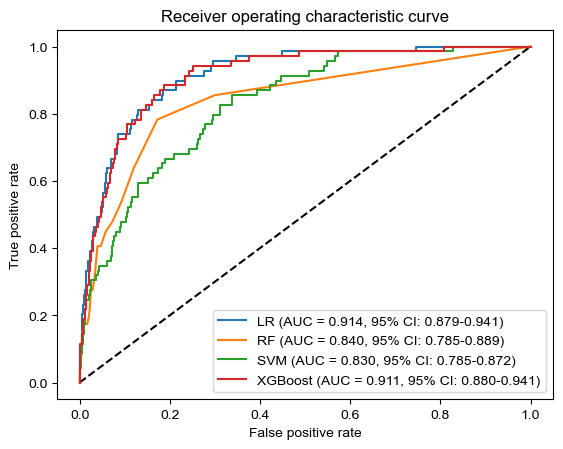

In [45]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
fpr1, tpr1, thresholds = roc_curve(y_true, probs1)
fpr2, tpr2, thresholds = roc_curve(y_true, probs2)
fpr3, tpr3, thresholds = roc_curve(y_true, probs3)
fpr4, tpr4, thresholds = roc_curve(y_true, probs4)
plt.rcParams['font.family'] = 'Arial'
params = plt.rcParams
font_family = params['font.family']
font_name = params['font.sans-serif'][0]
print("当前字体设置：")
print("字体系列：", font_family)
print("字体名称：", font_name)
from sklearn.metrics import roc_curve, auc
roc_auc1 = auc(fpr1, tpr1)
roc_auc2 = auc(fpr2, tpr2)
roc_auc3 = auc(fpr3, tpr3)
roc_auc4 = auc(fpr4, tpr4)
fig1 = plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr1, tpr1, label='LR (AUC = %0.3f, 95%% CI: %0.3f-%0.3f)' % (roc_auc1, lower1, upper1))
plt.plot(fpr2, tpr2, label='RF (AUC = %0.3f, 95%% CI: %0.3f-%0.3f)' % (roc_auc2, lower2, upper2))
plt.plot(fpr3, tpr3, label='SVM (AUC = %0.3f, 95%% CI: %0.3f-%0.3f)' % (roc_auc3, lower3, upper3))
plt.plot(fpr4, tpr4, label='XGBoost (AUC = %0.3f, 95%% CI: %0.3f-%0.3f)' % (roc_auc4, lower4, upper4))
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")

In [46]:
from matplotlib.backends.backend_pdf import PdfPages
# 保存为PDF格式
with PdfPages('roc_curve-生活方式+检验学指标-3年心因死亡.pdf') as pdf:
    pdf.savefig(fig1)
    plt.close()

In [47]:
selected_columns = [
    "SEQN","Doctor told you have diabetes", "Education Level - Adults 20+", "Ever told you had a stroke",
    "Ever told you had coronary heart disease", "Ever told you had high blood pressure",
    "Had at least 12 alcohol drinks/1 yr?", "Marital Status", "Moderate recreational activities",
    "Moderate work activity", "Race", "Smoked at least 100 cigarettes in life", 
    "Vigorous recreational activities", "Vigorous work activity", "Walk or bicycle", "Age", 
    "Minutes sedentary activity", "Ratio of family income to poverty", "Waist Circumference (cm)", 
    "3 year heart death"
]
df2 = df1[selected_columns]

In [49]:
first_col = df2.iloc[:, 0]
last_col = df2.iloc[:, -1]
for col in df2.columns[1:15]:
    df2[col] = df2[col].astype('category')
df_encoded = pd.get_dummies(df2.iloc[:, 1:15], drop_first=True)
scaler = StandardScaler()
df_standardized = pd.DataFrame(scaler.fit_transform(df2.iloc[:, 15:-1]), columns=df2.columns[15:-1])
df3 = pd.concat([first_col, df_encoded, df_standardized, last_col], axis=1)

C:\Users\wzc\AppData\Local\Temp\ipykernel_23972\3438547318.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[col] = df2[col].astype('category')


In [51]:
x = df3.iloc[:, 1:30]
y = df3['3 year heart death']

In [14]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
from sklearn.linear_model import LogisticRegression
estimator = LogisticRegression(max_iter=200)
estimator.fit(x_train, y_train)
from sklearn.metrics import roc_auc_score
y_true = y_test
probs1 = estimator.predict_proba(x_test)[:, 1]
auc_LR = roc_auc_score(y_true, probs1)
from sklearn.utils import resample
import numpy as np
n_iterations = 1000
auc_scores = []

for i in range(n_iterations):
    x_test_resampled, y_test_resampled = resample(x_test, y_test, replace=True)
    y_pred_resampled = estimator.predict_proba(x_test_resampled)[:, 1]
    auc_resampled = roc_auc_score(y_test_resampled, y_pred_resampled)
    auc_scores.append(auc_resampled)
alpha = 0.95
lower1 = np.percentile(auc_scores, (1 - alpha) / 2 * 100)
upper1 = np.percentile(auc_scores, (1 + alpha) / 2 * 100)
print(f"AUC: {auc_LR:.3f} ({lower1:.3f}-{upper1:.3f})")

NameError: name 'x' is not defined

In [55]:
import joblib
joblib.dump(estimator, 'LR-生活方式-3年心因死亡.joblib')

['LR-生活方式-3年心因死亡.joblib']

In [15]:
from sklearn.ensemble import RandomForestClassifier
estimator = RandomForestClassifier()
estimator.fit(x_train, y_train)
probs2 = estimator.predict_proba(x_test)[:, 1]
auc_RF = roc_auc_score(y_true, probs2)
n_iterations = 1000
auc_scores = []

for i in range(n_iterations):
    x_test_resampled, y_test_resampled = resample(x_test, y_test, replace=True)
    y_pred_resampled = estimator.predict_proba(x_test_resampled)[:, 1]
    auc_resampled = roc_auc_score(y_test_resampled, y_pred_resampled)
    auc_scores.append(auc_resampled)
alpha = 0.95
lower2 = np.percentile(auc_scores, (1 - alpha) / 2 * 100)
upper2 = np.percentile(auc_scores, (1 + alpha) / 2 * 100)
print(f"AUC: {auc_RF:.3f} ({lower2:.3f}-{upper2:.3f})")

NameError: name 'x_train' is not defined

In [57]:
import joblib
joblib.dump(estimator, 'RF-生活方式-3年心因死亡.joblib')

['RF-生活方式-3年心因死亡.joblib']

In [58]:
from sklearn.svm import SVC
estimator = SVC(probability=True)
estimator.fit(x_train, y_train)
probs3 = estimator.predict_proba(x_test)[:, 1]
auc_SVM = roc_auc_score(y_true, probs3)
n_iterations = 1000
auc_scores = []

for i in range(n_iterations):
    x_test_resampled, y_test_resampled = resample(x_test, y_test, replace=True)
    y_pred_resampled = estimator.predict_proba(x_test_resampled)[:, 1]
    auc_resampled = roc_auc_score(y_test_resampled, y_pred_resampled)
    auc_scores.append(auc_resampled)
alpha = 0.95
lower3 = np.percentile(auc_scores, (1 - alpha) / 2 * 100)
upper3 = np.percentile(auc_scores, (1 + alpha) / 2 * 100)
print(f"AUC: {auc_SVM:.3f} ({lower3:.3f}-{upper3:.3f})")

AUC: 0.797 (0.742-0.848)


In [59]:
import joblib
joblib.dump(estimator, 'SVM-生活方式-3年心因死亡.joblib')

['SVM-生活方式-3年心因死亡.joblib']

In [60]:
import xgboost as xgb
estimator = xgb.XGBClassifier()
estimator.fit(x_train, y_train)
probs4 = estimator.predict_proba(x_test)[:, 1]
auc_XGBoost = roc_auc_score(y_true, probs4)
n_iterations = 1000
auc_scores = []

for i in range(n_iterations):
    x_test_resampled, y_test_resampled = resample(x_test, y_test, replace=True)
    y_pred_resampled = estimator.predict_proba(x_test_resampled)[:, 1]
    auc_resampled = roc_auc_score(y_test_resampled, y_pred_resampled)
    auc_scores.append(auc_resampled)
alpha = 0.95
lower4 = np.percentile(auc_scores, (1 - alpha) / 2 * 100)
upper4 = np.percentile(auc_scores, (1 + alpha) / 2 * 100)
print(f"AUC: {auc_XGBoost:.3f} ({lower4:.3f}-{upper4:.3f})")

AUC: 0.842 (0.799-0.878)


In [61]:
import joblib
joblib.dump(estimator, 'XGBoost-生活方式-3年心因死亡.joblib')

['XGBoost-生活方式-3年心因死亡.joblib']

当前字体设置：
字体系列： ['Arial']
字体名称： DejaVu Sans


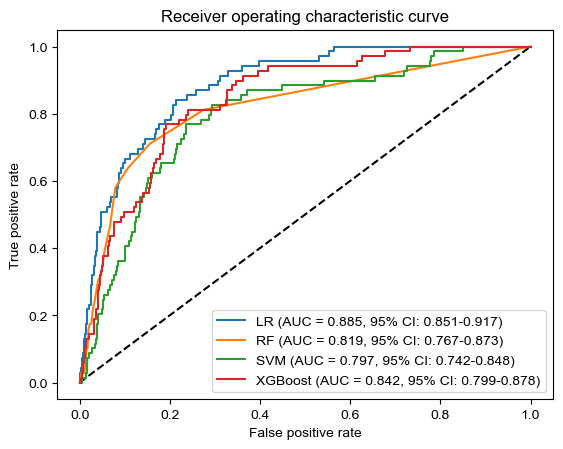

In [62]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
fpr1, tpr1, thresholds = roc_curve(y_true, probs1)
fpr2, tpr2, thresholds = roc_curve(y_true, probs2)
fpr3, tpr3, thresholds = roc_curve(y_true, probs3)
fpr4, tpr4, thresholds = roc_curve(y_true, probs4)
plt.rcParams['font.family'] = 'Arial'
params = plt.rcParams
font_family = params['font.family']
font_name = params['font.sans-serif'][0]
print("当前字体设置：")
print("字体系列：", font_family)
print("字体名称：", font_name)
from sklearn.metrics import roc_curve, auc
roc_auc1 = auc(fpr1, tpr1)
roc_auc2 = auc(fpr2, tpr2)
roc_auc3 = auc(fpr3, tpr3)
roc_auc4 = auc(fpr4, tpr4)
fig1 = plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr1, tpr1, label='LR (AUC = %0.3f, 95%% CI: %0.3f-%0.3f)' % (roc_auc1, lower1, upper1))
plt.plot(fpr2, tpr2, label='RF (AUC = %0.3f, 95%% CI: %0.3f-%0.3f)' % (roc_auc2, lower2, upper2))
plt.plot(fpr3, tpr3, label='SVM (AUC = %0.3f, 95%% CI: %0.3f-%0.3f)' % (roc_auc3, lower3, upper3))
plt.plot(fpr4, tpr4, label='XGBoost (AUC = %0.3f, 95%% CI: %0.3f-%0.3f)' % (roc_auc4, lower4, upper4))
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")

In [63]:
from matplotlib.backends.backend_pdf import PdfPages
with PdfPages('roc_curve-生活方式-3年心因死亡.pdf') as pdf:
    pdf.savefig(fig1)
    plt.close()

In [64]:
selected_columns = [
    "SEQN", "Alanine Aminotransferase (ALT) (U/L)", "Albumin (g/L)", "Albumin_urine (mg/L)", 
    "Alkaline Phosphatase (ALP) (IU/L)", "Bicarbonate (mmol/L)", "Blood urea nitrogen (mmol/L)", 
    "Chloride (mmol/L)", "Cholesterol (mmol/L)", "Creatinine (?mol/L)", "Creatinine_urine (umol/L)", 
    "Direct HDL-Cholesterol (mmol/L)", "Gamma Glutamyl Transferase (GGT) (U/L)", "Globulin (g/L)", 
    "Glucose_serum (mmol/L)", "Glycohemoglobin (%)", "Hematocrit (%)", "Hemoglobin (g/dL)", 
    "Iron_refigerated (umol/L)", "Lactate Dehydrogenase (LDH) (U/L)", "Lymphocyte number (1000 cells/uL)", 
    "Lymphocyte percent (%)", "Mean cell hemoglobin (pg)", "Mean cell hemoglobin concentration (g/dL)", 
    "Mean cell volume (fL)", "Monocyte number (1000 cells/uL)", "Monocyte percent (%)", 
    "Osmolality (mmol/Kg)", "Phosphorus (mmol/L)", "Platelet count (1000 cells/uL)", 
    "Potassium (mmol/L)", "Red blood cell count (million cells/uL)", "Red cell distribution width (%)", 
    "Segmented neutrophils num (1000 cell/uL)", "Segmented neutrophils percent (%)", 
    "Total protein (g/L)", "Uric acid (umol/L)", "3 year heart death"
]
df2 = df1[selected_columns]

In [66]:
first_col = df2.iloc[:, 0]
last_col = df2.iloc[:, -1]
scaler = StandardScaler()
df_standardized = pd.DataFrame(scaler.fit_transform(df2.iloc[:, 1:37]), columns=df2.columns[1:37])
df3 = pd.concat([first_col, df_standardized, last_col], axis=1)

In [68]:
x = df3.iloc[:, 1:37]
y = df3['3 year heart death']

In [71]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
from sklearn.linear_model import LogisticRegression
estimator = LogisticRegression(max_iter=200)
estimator.fit(x_train, y_train)
from sklearn.metrics import roc_auc_score
y_true = y_test
probs1 = estimator.predict_proba(x_test)[:, 1]
auc_LR = roc_auc_score(y_true, probs1)
from sklearn.utils import resample
import numpy as np
n_iterations = 1000
auc_scores = []

for i in range(n_iterations):
    x_test_resampled, y_test_resampled = resample(x_test, y_test, replace=True)
    y_pred_resampled = estimator.predict_proba(x_test_resampled)[:, 1]
    auc_resampled = roc_auc_score(y_test_resampled, y_pred_resampled)
    auc_scores.append(auc_resampled)
alpha = 0.95
lower1 = np.percentile(auc_scores, (1 - alpha) / 2 * 100)
upper1 = np.percentile(auc_scores, (1 + alpha) / 2 * 100)
print(f"AUC: {auc_LR:.3f} ({lower1:.3f}-{upper1:.3f})")

AUC: 0.886 (0.846-0.920)


In [72]:
import joblib
joblib.dump(estimator, 'LR-检验学指标-3年心因死亡.joblib')

['LR-检验学指标-3年心因死亡.joblib']

In [73]:
from sklearn.ensemble import RandomForestClassifier
estimator = RandomForestClassifier()
estimator.fit(x_train, y_train)
probs2 = estimator.predict_proba(x_test)[:, 1]
auc_RF = roc_auc_score(y_true, probs2)
n_iterations = 1000
auc_scores = []

for i in range(n_iterations):
    x_test_resampled, y_test_resampled = resample(x_test, y_test, replace=True)
    y_pred_resampled = estimator.predict_proba(x_test_resampled)[:, 1]
    auc_resampled = roc_auc_score(y_test_resampled, y_pred_resampled)
    auc_scores.append(auc_resampled)
alpha = 0.95
lower2 = np.percentile(auc_scores, (1 - alpha) / 2 * 100)
upper2 = np.percentile(auc_scores, (1 + alpha) / 2 * 100)
print(f"AUC: {auc_RF:.3f} ({lower2:.3f}-{upper2:.3f})")

AUC: 0.783 (0.722-0.840)


In [74]:
import joblib
joblib.dump(estimator, 'RF-检验学指标-3年心因死亡.joblib')

['RF-检验学指标-3年心因死亡.joblib']

In [75]:
from sklearn.svm import SVC
estimator = SVC(probability=True)
estimator.fit(x_train, y_train)
probs3 = estimator.predict_proba(x_test)[:, 1]
auc_SVM = roc_auc_score(y_true, probs3)
n_iterations = 1000
auc_scores = []

for i in range(n_iterations):
    x_test_resampled, y_test_resampled = resample(x_test, y_test, replace=True)
    y_pred_resampled = estimator.predict_proba(x_test_resampled)[:, 1]
    auc_resampled = roc_auc_score(y_test_resampled, y_pred_resampled)
    auc_scores.append(auc_resampled)
alpha = 0.95
lower3 = np.percentile(auc_scores, (1 - alpha) / 2 * 100)
upper3 = np.percentile(auc_scores, (1 + alpha) / 2 * 100)
print(f"AUC: {auc_SVM:.3f} ({lower3:.3f}-{upper3:.3f})")

AUC: 0.782 (0.725-0.835)


In [76]:
import joblib
joblib.dump(estimator, 'SVM-检验学指标-3年心因死亡.joblib')

['SVM-检验学指标-3年心因死亡.joblib']

In [77]:
import xgboost as xgb
estimator = xgb.XGBClassifier()
estimator.fit(x_train, y_train)
probs4 = estimator.predict_proba(x_test)[:, 1]
auc_XGBoost = roc_auc_score(y_true, probs4)
n_iterations = 1000
auc_scores = []

for i in range(n_iterations):
    x_test_resampled, y_test_resampled = resample(x_test, y_test, replace=True)
    y_pred_resampled = estimator.predict_proba(x_test_resampled)[:, 1]
    auc_resampled = roc_auc_score(y_test_resampled, y_pred_resampled)
    auc_scores.append(auc_resampled)
alpha = 0.95
lower4 = np.percentile(auc_scores, (1 - alpha) / 2 * 100)
upper4 = np.percentile(auc_scores, (1 + alpha) / 2 * 100)
print(f"AUC: {auc_XGBoost:.3f} ({lower4:.3f}-{upper4:.3f})")

AUC: 0.860 (0.820-0.898)


In [78]:
import joblib
joblib.dump(estimator, 'XGBoost-检验学指标-3年心因死亡.joblib')

['XGBoost-检验学指标-3年心因死亡.joblib']

当前字体设置：
字体系列： ['Arial']
字体名称： DejaVu Sans


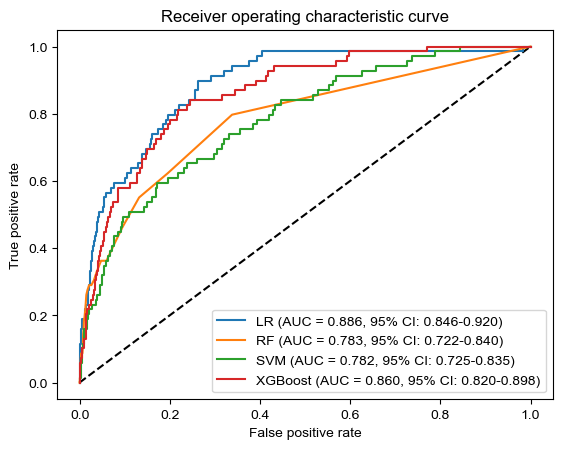

In [79]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
fpr1, tpr1, thresholds = roc_curve(y_true, probs1)
fpr2, tpr2, thresholds = roc_curve(y_true, probs2)
fpr3, tpr3, thresholds = roc_curve(y_true, probs3)
fpr4, tpr4, thresholds = roc_curve(y_true, probs4)
plt.rcParams['font.family'] = 'Arial'
params = plt.rcParams
font_family = params['font.family']
font_name = params['font.sans-serif'][0]
print("当前字体设置：")
print("字体系列：", font_family)
print("字体名称：", font_name)
from sklearn.metrics import roc_curve, auc
roc_auc1 = auc(fpr1, tpr1)
roc_auc2 = auc(fpr2, tpr2)
roc_auc3 = auc(fpr3, tpr3)
roc_auc4 = auc(fpr4, tpr4)
fig1 = plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr1, tpr1, label='LR (AUC = %0.3f, 95%% CI: %0.3f-%0.3f)' % (roc_auc1, lower1, upper1))
plt.plot(fpr2, tpr2, label='RF (AUC = %0.3f, 95%% CI: %0.3f-%0.3f)' % (roc_auc2, lower2, upper2))
plt.plot(fpr3, tpr3, label='SVM (AUC = %0.3f, 95%% CI: %0.3f-%0.3f)' % (roc_auc3, lower3, upper3))
plt.plot(fpr4, tpr4, label='XGBoost (AUC = %0.3f, 95%% CI: %0.3f-%0.3f)' % (roc_auc4, lower4, upper4))
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")

In [80]:
from matplotlib.backends.backend_pdf import PdfPages
with PdfPages('roc_curve-检验学指标-3年心因死亡.pdf') as pdf:
    pdf.savefig(fig1)
    plt.close()

In [2]:
df1 = pd.read_csv(r"D:\临床数据\NHANES数据清洗\5年心因死亡数据2.csv", low_memory=False)

In [4]:
selected_columns = [
    "SEQN","Gender","Doctor told you have diabetes", "Education Level - Adults 20+", "Ever told you had a stroke",
    "Ever told you had coronary heart disease", "Ever told you had high blood pressure",
    "Had at least 12 alcohol drinks/1 yr?", "Marital Status", "Moderate recreational activities",
    "Moderate work activity", "Race", "Smoked at least 100 cigarettes in life", 
    "Vigorous recreational activities", "Vigorous work activity", "Walk or bicycle", "Age", 
    "Minutes sedentary activity", "Ratio of family income to poverty", "Waist Circumference (cm)", 
    "Alanine Aminotransferase (ALT) (U/L)", "Albumin (g/L)", "Albumin_urine (mg/L)", 
    "Alkaline Phosphatase (ALP) (IU/L)", "Bicarbonate (mmol/L)", "Blood urea nitrogen (mmol/L)", 
    "Chloride (mmol/L)", "Cholesterol (mmol/L)", "Creatinine (?mol/L)", "Creatinine_urine (umol/L)", 
    "Direct HDL-Cholesterol (mmol/L)", "Gamma Glutamyl Transferase (GGT) (U/L)", "Globulin (g/L)", 
    "Glucose_serum (mmol/L)", "Glycohemoglobin (%)", "Hematocrit (%)", "Hemoglobin (g/dL)", 
    "Iron_refigerated (umol/L)", "Lactate Dehydrogenase (LDH) (U/L)", "Lymphocyte number (1000 cells/uL)", 
    "Lymphocyte percent (%)", "Mean cell hemoglobin (pg)", "Mean cell hemoglobin concentration (g/dL)", 
    "Mean cell volume (fL)", "Monocyte number (1000 cells/uL)", "Monocyte percent (%)", 
    "Osmolality (mmol/Kg)", "Phosphorus (mmol/L)", "Platelet count (1000 cells/uL)", 
    "Potassium (mmol/L)", "Red blood cell count (million cells/uL)", "Red cell distribution width (%)", 
    "Segmented neutrophils num (1000 cell/uL)", "Segmented neutrophils percent (%)", 
    "Total protein (g/L)", "Uric acid (umol/L)","Sodium (mmol/L)","Total bilirubin (umol/L)","Total calcium (mmol/L)","Triglycerides (mmol/L)",
    "5 year heart death"
]
df2 = df1[selected_columns]

In [8]:
first_col = df2.iloc[:, 0]
last_col = df2.iloc[:, -1]
for col in df2.columns[1:16]:
    df2[col] = df2[col].astype('category')
df_encoded = pd.get_dummies(df2.iloc[:, 1:16], drop_first=True)
scaler = StandardScaler()
df_standardized = pd.DataFrame(scaler.fit_transform(df2.iloc[:, 16:-1]), columns=df2.columns[16:-1])
df3 = pd.concat([first_col, df_encoded, df_standardized, last_col], axis=1)

C:\Users\wzc\AppData\Local\Temp\ipykernel_22108\1245546008.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[col] = df2[col].astype('category')


In [10]:
x = df3.iloc[:, 1:71]
y = df3['5 year heart death']

In [12]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
from sklearn.linear_model import LogisticRegression
estimator = LogisticRegression(max_iter=200)
estimator.fit(x_train, y_train)
from sklearn.metrics import roc_auc_score
y_true = y_test
probs1 = estimator.predict_proba(x_test)[:, 1]
auc_LR = roc_auc_score(y_true, probs1)
from sklearn.utils import resample
import numpy as np
n_iterations = 1000
auc_scores = []

for i in range(n_iterations):
    x_test_resampled, y_test_resampled = resample(x_test, y_test, replace=True)
    y_pred_resampled = estimator.predict_proba(x_test_resampled)[:, 1]
    auc_resampled = roc_auc_score(y_test_resampled, y_pred_resampled)
    auc_scores.append(auc_resampled)
alpha = 0.95
lower1 = np.percentile(auc_scores, (1 - alpha) / 2 * 100)
upper1 = np.percentile(auc_scores, (1 + alpha) / 2 * 100)
print(f"AUC: {auc_LR:.3f} ({lower1:.3f}-{upper1:.3f})")

AUC: 0.923 (0.895-0.946)


In [13]:
import joblib
joblib.dump(estimator, 'LR-生活方式+检验学指标-5年心因死亡.joblib')

['LR-生活方式+检验学指标-5年心因死亡.joblib']

In [14]:
from sklearn.ensemble import RandomForestClassifier
estimator = RandomForestClassifier()
estimator.fit(x_train, y_train)
probs2 = estimator.predict_proba(x_test)[:, 1]
auc_RF = roc_auc_score(y_true, probs2)
n_iterations = 1000
auc_scores = []

for i in range(n_iterations):
    x_test_resampled, y_test_resampled = resample(x_test, y_test, replace=True)
    y_pred_resampled = estimator.predict_proba(x_test_resampled)[:, 1]
    auc_resampled = roc_auc_score(y_test_resampled, y_pred_resampled)
    auc_scores.append(auc_resampled)
alpha = 0.95
lower2 = np.percentile(auc_scores, (1 - alpha) / 2 * 100)
upper2 = np.percentile(auc_scores, (1 + alpha) / 2 * 100)
print(f"AUC: {auc_RF:.3f} ({lower2:.3f}-{upper2:.3f})")

AUC: 0.895 (0.861-0.925)


In [15]:
import joblib
joblib.dump(estimator, 'RF-生活方式+检验学指标-5年心因死亡.joblib')

['RF-生活方式+检验学指标-5年心因死亡.joblib']

In [16]:
from sklearn.svm import SVC
estimator = SVC(probability=True)
estimator.fit(x_train, y_train)
probs3 = estimator.predict_proba(x_test)[:, 1]
auc_SVM = roc_auc_score(y_true, probs3)
n_iterations = 1000
auc_scores = []

for i in range(n_iterations):
    x_test_resampled, y_test_resampled = resample(x_test, y_test, replace=True)
    y_pred_resampled = estimator.predict_proba(x_test_resampled)[:, 1]
    auc_resampled = roc_auc_score(y_test_resampled, y_pred_resampled)
    auc_scores.append(auc_resampled)
alpha = 0.95
lower3 = np.percentile(auc_scores, (1 - alpha) / 2 * 100)
upper3 = np.percentile(auc_scores, (1 + alpha) / 2 * 100)
print(f"AUC: {auc_SVM:.3f} ({lower3:.3f}-{upper3:.3f})")

AUC: 0.868 (0.836-0.898)


In [17]:
import joblib
joblib.dump(estimator, 'SVM-生活方式+检验学指标-5年心因死亡.joblib')

['SVM-生活方式+检验学指标-5年心因死亡.joblib']

In [18]:
import xgboost as xgb
estimator = xgb.XGBClassifier()
estimator.fit(x_train, y_train)
probs4 = estimator.predict_proba(x_test)[:, 1]
auc_XGBoost = roc_auc_score(y_true, probs4)
n_iterations = 1000
auc_scores = []

for i in range(n_iterations):
    x_test_resampled, y_test_resampled = resample(x_test, y_test, replace=True)
    y_pred_resampled = estimator.predict_proba(x_test_resampled)[:, 1]
    auc_resampled = roc_auc_score(y_test_resampled, y_pred_resampled)
    auc_scores.append(auc_resampled)
alpha = 0.95
lower4 = np.percentile(auc_scores, (1 - alpha) / 2 * 100)
upper4 = np.percentile(auc_scores, (1 + alpha) / 2 * 100)
print(f"AUC: {auc_XGBoost:.3f} ({lower4:.3f}-{upper4:.3f})")

AUC: 0.910 (0.886-0.933)


In [19]:
import joblib
joblib.dump(estimator, 'XGBoost-生活方式+检验学指标-5年心因死亡.joblib')

['XGBoost-生活方式+检验学指标-5年心因死亡.joblib']

当前字体设置：
字体系列： ['Arial']
字体名称： DejaVu Sans


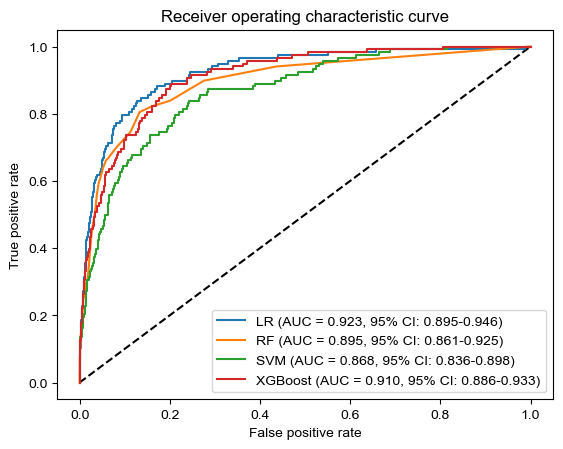

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
fpr1, tpr1, thresholds = roc_curve(y_true, probs1)
fpr2, tpr2, thresholds = roc_curve(y_true, probs2)
fpr3, tpr3, thresholds = roc_curve(y_true, probs3)
fpr4, tpr4, thresholds = roc_curve(y_true, probs4)
plt.rcParams['font.family'] = 'Arial'
params = plt.rcParams
font_family = params['font.family']
font_name = params['font.sans-serif'][0]
print("当前字体设置：")
print("字体系列：", font_family)
print("字体名称：", font_name)
from sklearn.metrics import roc_curve, auc
roc_auc1 = auc(fpr1, tpr1)
roc_auc2 = auc(fpr2, tpr2)
roc_auc3 = auc(fpr3, tpr3)
roc_auc4 = auc(fpr4, tpr4)
fig1 = plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr1, tpr1, label='LR (AUC = %0.3f, 95%% CI: %0.3f-%0.3f)' % (roc_auc1, lower1, upper1))
plt.plot(fpr2, tpr2, label='RF (AUC = %0.3f, 95%% CI: %0.3f-%0.3f)' % (roc_auc2, lower2, upper2))
plt.plot(fpr3, tpr3, label='SVM (AUC = %0.3f, 95%% CI: %0.3f-%0.3f)' % (roc_auc3, lower3, upper3))
plt.plot(fpr4, tpr4, label='XGBoost (AUC = %0.3f, 95%% CI: %0.3f-%0.3f)' % (roc_auc4, lower4, upper4))
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")

In [21]:
from matplotlib.backends.backend_pdf import PdfPages
with PdfPages('roc_curve-生活方式+检验学指标-5年心因死亡.pdf') as pdf:
    pdf.savefig(fig1)
    plt.close()

In [22]:
x = df3.iloc[:, 1:31]
y = df3['5 year heart death']

In [24]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
from sklearn.linear_model import LogisticRegression
estimator = LogisticRegression(max_iter=200)
estimator.fit(x_train, y_train)
from sklearn.metrics import roc_auc_score
y_true = y_test
probs1 = estimator.predict_proba(x_test)[:, 1]
auc_LR = roc_auc_score(y_true, probs1)
from sklearn.utils import resample
import numpy as np
n_iterations = 1000
auc_scores = []

for i in range(n_iterations):
    x_test_resampled, y_test_resampled = resample(x_test, y_test, replace=True)
    y_pred_resampled = estimator.predict_proba(x_test_resampled)[:, 1]
    auc_resampled = roc_auc_score(y_test_resampled, y_pred_resampled)
    auc_scores.append(auc_resampled)
alpha = 0.95
lower1 = np.percentile(auc_scores, (1 - alpha) / 2 * 100)
upper1 = np.percentile(auc_scores, (1 + alpha) / 2 * 100)
print(f"AUC: {auc_LR:.3f} ({lower1:.3f}-{upper1:.3f})")

AUC: 0.905 (0.873-0.930)


In [25]:
import joblib
joblib.dump(estimator, 'LR-生活方式-5年心因死亡.joblib')

['LR-生活方式-5年心因死亡.joblib']

In [26]:
from sklearn.ensemble import RandomForestClassifier
estimator = RandomForestClassifier()
estimator.fit(x_train, y_train)
probs2 = estimator.predict_proba(x_test)[:, 1]
auc_RF = roc_auc_score(y_true, probs2)
n_iterations = 1000
auc_scores = []

for i in range(n_iterations):
    x_test_resampled, y_test_resampled = resample(x_test, y_test, replace=True)
    y_pred_resampled = estimator.predict_proba(x_test_resampled)[:, 1]
    auc_resampled = roc_auc_score(y_test_resampled, y_pred_resampled)
    auc_scores.append(auc_resampled)
alpha = 0.95
lower2 = np.percentile(auc_scores, (1 - alpha) / 2 * 100)
upper2 = np.percentile(auc_scores, (1 + alpha) / 2 * 100)
print(f"AUC: {auc_RF:.3f} ({lower2:.3f}-{upper2:.3f})")

AUC: 0.893 (0.860-0.921)


In [27]:
import joblib
joblib.dump(estimator, 'RF-生活方式-5年心因死亡.joblib')

['RF-生活方式-5年心因死亡.joblib']

In [28]:
from sklearn.svm import SVC
estimator = SVC(probability=True)
estimator.fit(x_train, y_train)
probs3 = estimator.predict_proba(x_test)[:, 1]
auc_SVM = roc_auc_score(y_true, probs3)
n_iterations = 1000
auc_scores = []

for i in range(n_iterations):
    x_test_resampled, y_test_resampled = resample(x_test, y_test, replace=True)
    y_pred_resampled = estimator.predict_proba(x_test_resampled)[:, 1]
    auc_resampled = roc_auc_score(y_test_resampled, y_pred_resampled)
    auc_scores.append(auc_resampled)
alpha = 0.95
lower3 = np.percentile(auc_scores, (1 - alpha) / 2 * 100)
upper3 = np.percentile(auc_scores, (1 + alpha) / 2 * 100)
print(f"AUC: {auc_SVM:.3f} ({lower3:.3f}-{upper3:.3f})")

AUC: 0.808 (0.768-0.846)


In [29]:
import joblib
joblib.dump(estimator, 'SVN-生活方式-5年心因死亡.joblib')

['SVN-生活方式-5年心因死亡.joblib']

In [30]:
import xgboost as xgb
estimator = xgb.XGBClassifier()
estimator.fit(x_train, y_train)
probs4 = estimator.predict_proba(x_test)[:, 1]
auc_XGBoost = roc_auc_score(y_true, probs4)
n_iterations = 1000
auc_scores = []

for i in range(n_iterations):
    x_test_resampled, y_test_resampled = resample(x_test, y_test, replace=True)
    y_pred_resampled = estimator.predict_proba(x_test_resampled)[:, 1]
    auc_resampled = roc_auc_score(y_test_resampled, y_pred_resampled)
    auc_scores.append(auc_resampled)
alpha = 0.95
lower4 = np.percentile(auc_scores, (1 - alpha) / 2 * 100)
upper4 = np.percentile(auc_scores, (1 + alpha) / 2 * 100)
print(f"AUC: {auc_XGBoost:.3f} ({lower4:.3f}-{upper4:.3f})")

AUC: 0.897 (0.875-0.917)


In [31]:
import joblib
joblib.dump(estimator, 'XGBoost-生活方式-5年心因死亡.joblib')

['XGBoost-生活方式-5年心因死亡.joblib']

当前字体设置：
字体系列： ['Arial']
字体名称： DejaVu Sans


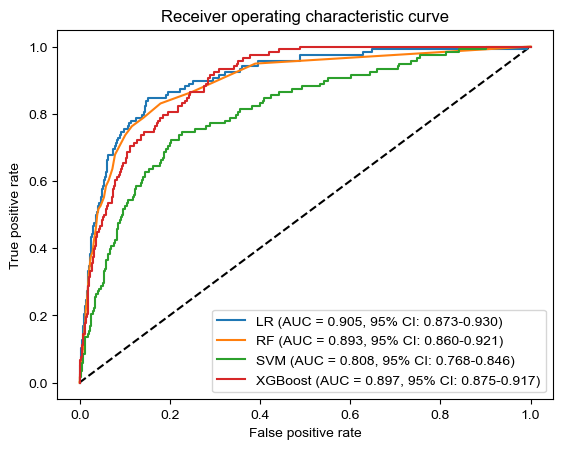

In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
fpr1, tpr1, thresholds = roc_curve(y_true, probs1)
fpr2, tpr2, thresholds = roc_curve(y_true, probs2)
fpr3, tpr3, thresholds = roc_curve(y_true, probs3)
fpr4, tpr4, thresholds = roc_curve(y_true, probs4)
plt.rcParams['font.family'] = 'Arial'
params = plt.rcParams
font_family = params['font.family']
font_name = params['font.sans-serif'][0]
print("当前字体设置：")
print("字体系列：", font_family)
print("字体名称：", font_name)
from sklearn.metrics import roc_curve, auc
roc_auc1 = auc(fpr1, tpr1)
roc_auc2 = auc(fpr2, tpr2)
roc_auc3 = auc(fpr3, tpr3)
roc_auc4 = auc(fpr4, tpr4)
fig1 = plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr1, tpr1, label='LR (AUC = %0.3f, 95%% CI: %0.3f-%0.3f)' % (roc_auc1, lower1, upper1))
plt.plot(fpr2, tpr2, label='RF (AUC = %0.3f, 95%% CI: %0.3f-%0.3f)' % (roc_auc2, lower2, upper2))
plt.plot(fpr3, tpr3, label='SVM (AUC = %0.3f, 95%% CI: %0.3f-%0.3f)' % (roc_auc3, lower3, upper3))
plt.plot(fpr4, tpr4, label='XGBoost (AUC = %0.3f, 95%% CI: %0.3f-%0.3f)' % (roc_auc4, lower4, upper4))
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")

In [33]:
from matplotlib.backends.backend_pdf import PdfPages
with PdfPages('roc_curve-生活方式-5年心因死亡.pdf') as pdf:
    pdf.savefig(fig1)
    plt.close()

In [34]:
x = df3.iloc[:, 31:71]
y = df3['5 year heart death']

In [36]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
from sklearn.linear_model import LogisticRegression
estimator = LogisticRegression(max_iter=200)
estimator.fit(x_train, y_train)
from sklearn.metrics import roc_auc_score
y_true = y_test
probs1 = estimator.predict_proba(x_test)[:, 1]
auc_LR = roc_auc_score(y_true, probs1)
from sklearn.utils import resample
import numpy as np
n_iterations = 1000
auc_scores = []

for i in range(n_iterations):
    x_test_resampled, y_test_resampled = resample(x_test, y_test, replace=True)
    y_pred_resampled = estimator.predict_proba(x_test_resampled)[:, 1]
    auc_resampled = roc_auc_score(y_test_resampled, y_pred_resampled)
    auc_scores.append(auc_resampled)
alpha = 0.95
lower1 = np.percentile(auc_scores, (1 - alpha) / 2 * 100)
upper1 = np.percentile(auc_scores, (1 + alpha) / 2 * 100)
print(f"AUC: {auc_LR:.3f} ({lower1:.3f}-{upper1:.3f})")

AUC: 0.861 (0.821-0.895)


In [37]:
import joblib
joblib.dump(estimator, 'LR-检验学指标-5年心因死亡.joblib')

['LR-检验学指标-5年心因死亡.joblib']

In [38]:
from sklearn.ensemble import RandomForestClassifier
estimator = RandomForestClassifier()
estimator.fit(x_train, y_train)
probs2 = estimator.predict_proba(x_test)[:, 1]
auc_RF = roc_auc_score(y_true, probs2)
n_iterations = 1000
auc_scores = []

for i in range(n_iterations):
    x_test_resampled, y_test_resampled = resample(x_test, y_test, replace=True)
    y_pred_resampled = estimator.predict_proba(x_test_resampled)[:, 1]
    auc_resampled = roc_auc_score(y_test_resampled, y_pred_resampled)
    auc_scores.append(auc_resampled)
alpha = 0.95
lower2 = np.percentile(auc_scores, (1 - alpha) / 2 * 100)
upper2 = np.percentile(auc_scores, (1 + alpha) / 2 * 100)
print(f"AUC: {auc_RF:.3f} ({lower2:.3f}-{upper2:.3f})")

AUC: 0.831 (0.788-0.870)


In [39]:
import joblib
joblib.dump(estimator, 'RF-检验学指标-5年心因死亡.joblib')

['RF-检验学指标-5年心因死亡.joblib']

In [40]:
from sklearn.svm import SVC
estimator = SVC(probability=True)
estimator.fit(x_train, y_train)
probs3 = estimator.predict_proba(x_test)[:, 1]
auc_SVM = roc_auc_score(y_true, probs3)
n_iterations = 1000
auc_scores = []

for i in range(n_iterations):
    x_test_resampled, y_test_resampled = resample(x_test, y_test, replace=True)
    y_pred_resampled = estimator.predict_proba(x_test_resampled)[:, 1]
    auc_resampled = roc_auc_score(y_test_resampled, y_pred_resampled)
    auc_scores.append(auc_resampled)
alpha = 0.95
lower3 = np.percentile(auc_scores, (1 - alpha) / 2 * 100)
upper3 = np.percentile(auc_scores, (1 + alpha) / 2 * 100)
print(f"AUC: {auc_SVM:.3f} ({lower3:.3f}-{upper3:.3f})")

AUC: 0.775 (0.728-0.825)


In [41]:
import joblib
joblib.dump(estimator, 'SVM-检验学指标-5年心因死亡.joblib')

['SVM-检验学指标-5年心因死亡.joblib']

In [42]:
import xgboost as xgb
estimator = xgb.XGBClassifier()
estimator.fit(x_train, y_train)
probs4 = estimator.predict_proba(x_test)[:, 1]
auc_XGBoost = roc_auc_score(y_true, probs4)
n_iterations = 1000
auc_scores = []

for i in range(n_iterations):
    x_test_resampled, y_test_resampled = resample(x_test, y_test, replace=True)
    y_pred_resampled = estimator.predict_proba(x_test_resampled)[:, 1]
    auc_resampled = roc_auc_score(y_test_resampled, y_pred_resampled)
    auc_scores.append(auc_resampled)
alpha = 0.95
lower4 = np.percentile(auc_scores, (1 - alpha) / 2 * 100)
upper4 = np.percentile(auc_scores, (1 + alpha) / 2 * 100)
print(f"AUC: {auc_XGBoost:.3f} ({lower4:.3f}-{upper4:.3f})")

AUC: 0.848 (0.811-0.879)


In [43]:
import joblib
joblib.dump(estimator, 'XGBoost-检验学指标-5年心因死亡.joblib')

['XGBoost-检验学指标-5年心因死亡.joblib']

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
fpr1, tpr1, thresholds = roc_curve(y_true, probs1)
fpr2, tpr2, thresholds = roc_curve(y_true, probs2)
fpr3, tpr3, thresholds = roc_curve(y_true, probs3)
fpr4, tpr4, thresholds = roc_curve(y_true, probs4)
plt.rcParams['font.family'] = 'Arial'
params = plt.rcParams
font_family = params['font.family']
font_name = params['font.sans-serif'][0]
print("当前字体设置：")
print("字体系列：", font_family)
print("字体名称：", font_name)
from sklearn.metrics import roc_curve, auc
roc_auc1 = auc(fpr1, tpr1)
roc_auc2 = auc(fpr2, tpr2)
roc_auc3 = auc(fpr3, tpr3)
roc_auc4 = auc(fpr4, tpr4)
fig1 = plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr1, tpr1, label='LR (AUC = %0.3f, 95%% CI: %0.3f-%0.3f)' % (roc_auc1, lower1, upper1))
plt.plot(fpr2, tpr2, label='RF (AUC = %0.3f, 95%% CI: %0.3f-%0.3f)' % (roc_auc2, lower2, upper2))
plt.plot(fpr3, tpr3, label='SVM (AUC = %0.3f, 95%% CI: %0.3f-%0.3f)' % (roc_auc3, lower3, upper3))
plt.plot(fpr4, tpr4, label='XGBoost (AUC = %0.3f, 95%% CI: %0.3f-%0.3f)' % (roc_auc4, lower4, upper4))
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")

NameError: name 'y_true' is not defined

In [45]:
from matplotlib.backends.backend_pdf import PdfPages
with PdfPages('roc_curve-检验学指标-5年心因死亡.pdf') as pdf:
    pdf.savefig(fig1)
    plt.close()

In [10]:
df1 = pd.read_csv(r"D:\临床数据\NHANES数据清洗\10年心因死亡数据.csv", low_memory=False)

In [11]:
selected_columns = [
    "SEQN","Gender","Doctor told you have diabetes", "Education Level - Adults 20+", "Ever told you had a stroke",
    "Ever told you had coronary heart disease", "Ever told you had high blood pressure",
    "Had at least 12 alcohol drinks/1 yr?", "Marital Status", "Moderate recreational activities",
    "Moderate work activity", "Race", "Smoked at least 100 cigarettes in life", 
    "Vigorous recreational activities", "Vigorous work activity", "Walk or bicycle", "Age", 
    "Minutes sedentary activity", "Ratio of family income to poverty", "Waist Circumference (cm)", 
    "Alanine Aminotransferase (ALT) (U/L)", "Albumin (g/L)", "Albumin_urine (mg/L)", 
    "Alkaline Phosphatase (ALP) (IU/L)", "Bicarbonate (mmol/L)", "Blood urea nitrogen (mmol/L)", 
    "Chloride (mmol/L)", "Cholesterol (mmol/L)", "Creatinine (umol/L)", "Creatinine_urine (umol/L)", 
    "Direct HDL-Cholesterol (mmol/L)", "Gamma Glutamyl Transferase (GGT) (U/L)", "Globulin (g/L)", 
    "Glucose_serum (mmol/L)", "Glycohemoglobin (%)", "Hematocrit (%)", "Hemoglobin (g/dL)", 
    "Iron_refigerated (umol/L)", "Lactate Dehydrogenase (LDH) (U/L)", "Lymphocyte number (1000 cells/uL)", 
    "Lymphocyte percent (%)", "Mean cell hemoglobin (pg)", "Mean cell hemoglobin concentration (g/dL)", 
    "Mean cell volume (fL)", "Monocyte number (1000 cells/uL)", "Monocyte percent (%)", 
    "Osmolality (mmol/Kg)", "Phosphorus (mmol/L)", "Platelet count (1000 cells/uL)", 
    "Potassium (mmol/L)", "Red blood cell count (million cells/uL)", "Red cell distribution width (%)", 
    "Segmented neutrophils num (1000 cell/uL)", "Segmented neutrophils percent (%)", 
    "Total protein (g/L)", "Uric acid (umol/L)","Sodium (mmol/L)","Total bilirubin (umol/L)","Total calcium (mmol/L)","Triglycerides (mmol/L)",
    "White blood cell count (1000 cells/uL)","Mean platelet volume (fL)", "10 year heart death"
]
df2 = df1[selected_columns]

In [12]:
first_col = df2.iloc[:, 0]
last_col = df2.iloc[:, -1]
for col in df2.columns[1:16]:
    df2[col] = df2[col].astype('category')
df_encoded = pd.get_dummies(df2.iloc[:, 1:16], drop_first=True)
scaler = StandardScaler()
df_standardized = pd.DataFrame(scaler.fit_transform(df2.iloc[:, 16:-1]), columns=df2.columns[16:-1])
df3 = pd.concat([first_col, df_encoded, df_standardized, last_col], axis=1)

C:\Users\wzc\AppData\Local\Temp\ipykernel_13812\1245546008.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[col] = df2[col].astype('category')


In [13]:
x = df3.iloc[:, 1:73]
y = df3['10 year heart death']

In [142]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
from sklearn.linear_model import LogisticRegression
estimator = LogisticRegression(max_iter=200)
estimator.fit(x_train, y_train)
from sklearn.metrics import roc_auc_score
y_true = y_test
probs1 = estimator.predict_proba(x_test)[:, 1]
auc_LR = roc_auc_score(y_true, probs1)
from sklearn.utils import resample
import numpy as np
n_iterations = 1000
auc_scores = []

for i in range(n_iterations):
    x_test_resampled, y_test_resampled = resample(x_test, y_test, replace=True)
    y_pred_resampled = estimator.predict_proba(x_test_resampled)[:, 1]
    auc_resampled = roc_auc_score(y_test_resampled, y_pred_resampled)
    auc_scores.append(auc_resampled)
alpha = 0.95
lower1 = np.percentile(auc_scores, (1 - alpha) / 2 * 100)
upper1 = np.percentile(auc_scores, (1 + alpha) / 2 * 100)
print(f"AUC: {auc_LR:.3f} ({lower1:.3f}-{upper1:.3f})")

AUC: 0.908 (0.886-0.929)


In [143]:
import joblib
joblib.dump(estimator, 'LR-生活方式+检验学指标-10年心因死亡.joblib')

['LR-生活方式+检验学指标-10年心因死亡.joblib']

In [144]:
from sklearn.ensemble import RandomForestClassifier
estimator = RandomForestClassifier()
estimator.fit(x_train, y_train)
probs2 = estimator.predict_proba(x_test)[:, 1]
auc_RF = roc_auc_score(y_true, probs2)
n_iterations = 1000
auc_scores = []

for i in range(n_iterations):
    x_test_resampled, y_test_resampled = resample(x_test, y_test, replace=True)
    y_pred_resampled = estimator.predict_proba(x_test_resampled)[:, 1]
    auc_resampled = roc_auc_score(y_test_resampled, y_pred_resampled)
    auc_scores.append(auc_resampled)

alpha = 0.95
lower2 = np.percentile(auc_scores, (1 - alpha) / 2 * 100)
upper2 = np.percentile(auc_scores, (1 + alpha) / 2 * 100)
print(f"AUC: {auc_RF:.3f} ({lower2:.3f}-{upper2:.3f})")

AUC: 0.893 (0.867-0.915)


In [145]:
import joblib
joblib.dump(estimator, 'RF-生活方式+检验学指标-10年心因死亡.joblib')

['RF-生活方式+检验学指标-10年心因死亡.joblib']

In [146]:
from sklearn.svm import SVC
estimator = SVC(probability=True)
estimator.fit(x_train, y_train)
probs3 = estimator.predict_proba(x_test)[:, 1]
auc_SVM = roc_auc_score(y_true, probs3)
n_iterations = 1000
auc_scores = []

for i in range(n_iterations):
    x_test_resampled, y_test_resampled = resample(x_test, y_test, replace=True)
    y_pred_resampled = estimator.predict_proba(x_test_resampled)[:, 1]
    auc_resampled = roc_auc_score(y_test_resampled, y_pred_resampled)
    auc_scores.append(auc_resampled)
alpha = 0.95
lower3 = np.percentile(auc_scores, (1 - alpha) / 2 * 100)
upper3 = np.percentile(auc_scores, (1 + alpha) / 2 * 100)
print(f"AUC: {auc_SVM:.3f} ({lower3:.3f}-{upper3:.3f})")

AUC: 0.872 (0.846-0.894)


In [147]:
import joblib
joblib.dump(estimator, 'SVM-生活方式+检验学指标-10年心因死亡.joblib')

['SVM-生活方式+检验学指标-10年心因死亡.joblib']

In [148]:
import xgboost as xgb
estimator = xgb.XGBClassifier()
estimator.fit(x_train, y_train)
probs4 = estimator.predict_proba(x_test)[:, 1]
auc_XGBoost = roc_auc_score(y_true, probs4)
n_iterations = 1000
auc_scores = []

for i in range(n_iterations):
    x_test_resampled, y_test_resampled = resample(x_test, y_test, replace=True)
    y_pred_resampled = estimator.predict_proba(x_test_resampled)[:, 1]
    auc_resampled = roc_auc_score(y_test_resampled, y_pred_resampled)
    auc_scores.append(auc_resampled)
alpha = 0.95
lower4 = np.percentile(auc_scores, (1 - alpha) / 2 * 100)
upper4 = np.percentile(auc_scores, (1 + alpha) / 2 * 100)
print(f"AUC: {auc_XGBoost:.3f} ({lower4:.3f}-{upper4:.3f})")

AUC: 0.893 (0.869-0.916)


In [149]:
import joblib
joblib.dump(estimator, 'XGBoost-生活方式+检验学指标-10年心因死亡.joblib')

['XGBoost-生活方式+检验学指标-10年心因死亡.joblib']

当前字体设置：
字体系列： ['Arial']
字体名称： DejaVu Sans


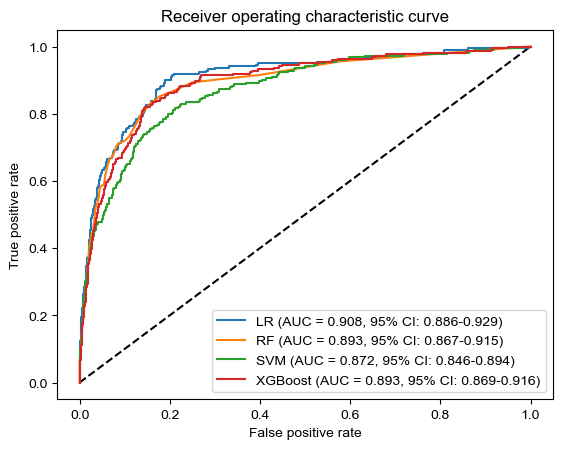

In [150]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
fpr1, tpr1, thresholds = roc_curve(y_true, probs1)
fpr2, tpr2, thresholds = roc_curve(y_true, probs2)
fpr3, tpr3, thresholds = roc_curve(y_true, probs3)
fpr4, tpr4, thresholds = roc_curve(y_true, probs4)
plt.rcParams['font.family'] = 'Arial'
params = plt.rcParams
font_family = params['font.family']
font_name = params['font.sans-serif'][0]
print("当前字体设置：")
print("字体系列：", font_family)
print("字体名称：", font_name)
from sklearn.metrics import roc_curve, auc
roc_auc1 = auc(fpr1, tpr1)
roc_auc2 = auc(fpr2, tpr2)
roc_auc3 = auc(fpr3, tpr3)
roc_auc4 = auc(fpr4, tpr4)
fig1 = plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr1, tpr1, label='LR (AUC = %0.3f, 95%% CI: %0.3f-%0.3f)' % (roc_auc1, lower1, upper1))
plt.plot(fpr2, tpr2, label='RF (AUC = %0.3f, 95%% CI: %0.3f-%0.3f)' % (roc_auc2, lower2, upper2))
plt.plot(fpr3, tpr3, label='SVM (AUC = %0.3f, 95%% CI: %0.3f-%0.3f)' % (roc_auc3, lower3, upper3))
plt.plot(fpr4, tpr4, label='XGBoost (AUC = %0.3f, 95%% CI: %0.3f-%0.3f)' % (roc_auc4, lower4, upper4))
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")

In [151]:
from matplotlib.backends.backend_pdf import PdfPages
with PdfPages('roc_curve-生活方式+检验学指标-10年心因死亡.pdf') as pdf:
    pdf.savefig(fig1)
    plt.close()

In [154]:
x = df3.iloc[:, 1:31]
y = df3['10 year heart death']

In [159]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
from sklearn.linear_model import LogisticRegression
estimator = LogisticRegression(max_iter=200)
estimator.fit(x_train, y_train)
from sklearn.metrics import roc_auc_score
y_true = y_test
probs1 = estimator.predict_proba(x_test)[:, 1]
auc_LR = roc_auc_score(y_true, probs1)
from sklearn.utils import resample
import numpy as np
n_iterations = 1000
auc_scores = []

for i in range(n_iterations):
    x_test_resampled, y_test_resampled = resample(x_test, y_test, replace=True)
    y_pred_resampled = estimator.predict_proba(x_test_resampled)[:, 1]
    auc_resampled = roc_auc_score(y_test_resampled, y_pred_resampled)
    auc_scores.append(auc_resampled)
alpha = 0.95
lower1 = np.percentile(auc_scores, (1 - alpha) / 2 * 100)
upper1 = np.percentile(auc_scores, (1 + alpha) / 2 * 100)
print(f"AUC: {auc_LR:.3f} ({lower1:.3f}-{upper1:.3f})")

AUC: 0.893 (0.870-0.916)


In [160]:
import joblib
joblib.dump(estimator, 'LR-生活方式-10年心因死亡.joblib')

['LR-生活方式-10年心因死亡.joblib']

In [157]:
from sklearn.ensemble import RandomForestClassifier
estimator = RandomForestClassifier()
estimator.fit(x_train, y_train)
probs2 = estimator.predict_proba(x_test)[:, 1]
auc_RF = roc_auc_score(y_true, probs2)
n_iterations = 1000
auc_scores = []

for i in range(n_iterations):
    x_test_resampled, y_test_resampled = resample(x_test, y_test, replace=True)
    y_pred_resampled = estimator.predict_proba(x_test_resampled)[:, 1]
    auc_resampled = roc_auc_score(y_test_resampled, y_pred_resampled)
    auc_scores.append(auc_resampled)
alpha = 0.95
lower2 = np.percentile(auc_scores, (1 - alpha) / 2 * 100)
upper2 = np.percentile(auc_scores, (1 + alpha) / 2 * 100)
print(f"AUC: {auc_RF:.3f} ({lower2:.3f}-{upper2:.3f})")

AUC: 0.881 (0.856-0.904)


In [158]:
import joblib
joblib.dump(estimator, 'RF-生活方式-10年心因死亡.joblib')

['RF-生活方式-10年心因死亡.joblib']

In [161]:
from sklearn.svm import SVC
estimator = SVC(probability=True)
estimator.fit(x_train, y_train)
probs3 = estimator.predict_proba(x_test)[:, 1]
auc_SVM = roc_auc_score(y_true, probs3)
n_iterations = 1000
auc_scores = []

for i in range(n_iterations):
    x_test_resampled, y_test_resampled = resample(x_test, y_test, replace=True)
    y_pred_resampled = estimator.predict_proba(x_test_resampled)[:, 1]
    auc_resampled = roc_auc_score(y_test_resampled, y_pred_resampled)
    auc_scores.append(auc_resampled)
alpha = 0.95
lower3 = np.percentile(auc_scores, (1 - alpha) / 2 * 100)
upper3 = np.percentile(auc_scores, (1 + alpha) / 2 * 100)
print(f"AUC: {auc_SVM:.3f} ({lower3:.3f}-{upper3:.3f})")

AUC: 0.814 (0.778-0.845)


In [162]:
import joblib
joblib.dump(estimator, 'SVM-生活方式-10年心因死亡.joblib')

['SVM-生活方式-10年心因死亡.joblib']

In [163]:
import xgboost as xgb
estimator = xgb.XGBClassifier()
estimator.fit(x_train, y_train)
probs4 = estimator.predict_proba(x_test)[:, 1]
auc_XGBoost = roc_auc_score(y_true, probs4)
n_iterations = 1000
auc_scores = []

for i in range(n_iterations):
    x_test_resampled, y_test_resampled = resample(x_test, y_test, replace=True)
    y_pred_resampled = estimator.predict_proba(x_test_resampled)[:, 1]
    auc_resampled = roc_auc_score(y_test_resampled, y_pred_resampled)
    auc_scores.append(auc_resampled)
alpha = 0.95
lower4 = np.percentile(auc_scores, (1 - alpha) / 2 * 100)
upper4 = np.percentile(auc_scores, (1 + alpha) / 2 * 100)
print(f"AUC: {auc_XGBoost:.3f} ({lower4:.3f}-{upper4:.3f})")

AUC: 0.874 (0.847-0.897)


In [164]:
joblib.dump(estimator, 'XGBoost-生活方式-10年心因死亡.joblib')

['XGBoost-生活方式-10年心因死亡.joblib']

当前字体设置：
字体系列： ['Arial']
字体名称： DejaVu Sans


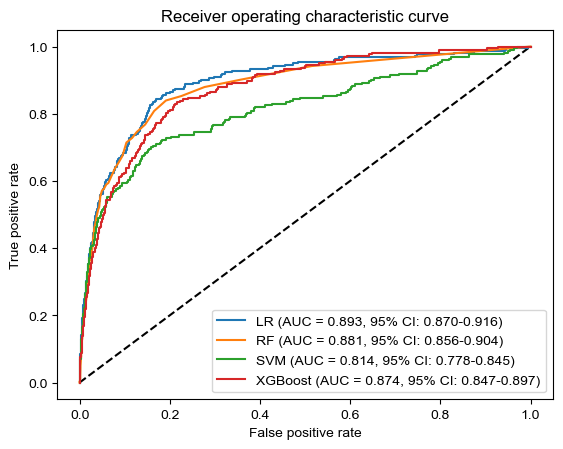

In [165]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
fpr1, tpr1, thresholds = roc_curve(y_true, probs1)
fpr2, tpr2, thresholds = roc_curve(y_true, probs2)
fpr3, tpr3, thresholds = roc_curve(y_true, probs3)
fpr4, tpr4, thresholds = roc_curve(y_true, probs4)
plt.rcParams['font.family'] = 'Arial'
params = plt.rcParams
font_family = params['font.family']
font_name = params['font.sans-serif'][0]
print("当前字体设置：")
print("字体系列：", font_family)
print("字体名称：", font_name)
from sklearn.metrics import roc_curve, auc
roc_auc1 = auc(fpr1, tpr1)
roc_auc2 = auc(fpr2, tpr2)
roc_auc3 = auc(fpr3, tpr3)
roc_auc4 = auc(fpr4, tpr4)
fig1 = plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr1, tpr1, label='LR (AUC = %0.3f, 95%% CI: %0.3f-%0.3f)' % (roc_auc1, lower1, upper1))
plt.plot(fpr2, tpr2, label='RF (AUC = %0.3f, 95%% CI: %0.3f-%0.3f)' % (roc_auc2, lower2, upper2))
plt.plot(fpr3, tpr3, label='SVM (AUC = %0.3f, 95%% CI: %0.3f-%0.3f)' % (roc_auc3, lower3, upper3))
plt.plot(fpr4, tpr4, label='XGBoost (AUC = %0.3f, 95%% CI: %0.3f-%0.3f)' % (roc_auc4, lower4, upper4))
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")

In [166]:
from matplotlib.backends.backend_pdf import PdfPages
with PdfPages('roc_curve-生活方式-10年心因死亡.pdf') as pdf:
    pdf.savefig(fig1)
    plt.close()

In [167]:
x = df3.iloc[:, 31:73]
y = df3['10 year heart death']

In [169]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
from sklearn.linear_model import LogisticRegression
estimator = LogisticRegression(max_iter=200)
estimator.fit(x_train, y_train)
from sklearn.metrics import roc_auc_score
y_true = y_test
probs1 = estimator.predict_proba(x_test)[:, 1]
auc_LR = roc_auc_score(y_true, probs1)
from sklearn.utils import resample
import numpy as np
n_iterations = 1000
auc_scores = []

for i in range(n_iterations):
    x_test_resampled, y_test_resampled = resample(x_test, y_test, replace=True)
    y_pred_resampled = estimator.predict_proba(x_test_resampled)[:, 1]
    auc_resampled = roc_auc_score(y_test_resampled, y_pred_resampled)
    auc_scores.append(auc_resampled)
alpha = 0.95
lower1 = np.percentile(auc_scores, (1 - alpha) / 2 * 100)
upper1 = np.percentile(auc_scores, (1 + alpha) / 2 * 100)
print(f"AUC: {auc_LR:.3f} ({lower1:.3f}-{upper1:.3f})")

AUC: 0.847 (0.816-0.872)


In [170]:
import joblib
joblib.dump(estimator, 'LR-检验学指标-10年心因死亡.joblib')

['LR-检验学指标-10年心因死亡.joblib']

In [171]:
from sklearn.ensemble import RandomForestClassifier
estimator = RandomForestClassifier()
estimator.fit(x_train, y_train)
probs2 = estimator.predict_proba(x_test)[:, 1]
auc_RF = roc_auc_score(y_true, probs2)
n_iterations = 1000
auc_scores = []

for i in range(n_iterations):
    x_test_resampled, y_test_resampled = resample(x_test, y_test, replace=True)
    y_pred_resampled = estimator.predict_proba(x_test_resampled)[:, 1]
    auc_resampled = roc_auc_score(y_test_resampled, y_pred_resampled)
    auc_scores.append(auc_resampled)
alpha = 0.95
lower2 = np.percentile(auc_scores, (1 - alpha) / 2 * 100)
upper2 = np.percentile(auc_scores, (1 + alpha) / 2 * 100)
print(f"AUC: {auc_RF:.3f} ({lower2:.3f}-{upper2:.3f})")

AUC: 0.826 (0.794-0.856)


In [172]:
import joblib
joblib.dump(estimator, 'RF-检验学指标-10年心因死亡.joblib')

['RF-检验学指标-10年心因死亡.joblib']

In [173]:
from sklearn.svm import SVC
estimator = SVC(probability=True)
estimator.fit(x_train, y_train)
probs3 = estimator.predict_proba(x_test)[:, 1]
auc_SVM = roc_auc_score(y_true, probs3)
n_iterations = 1000
auc_scores = []

for i in range(n_iterations):
    x_test_resampled, y_test_resampled = resample(x_test, y_test, replace=True)
    y_pred_resampled = estimator.predict_proba(x_test_resampled)[:, 1]
    auc_resampled = roc_auc_score(y_test_resampled, y_pred_resampled)
    auc_scores.append(auc_resampled)
alpha = 0.95
lower3 = np.percentile(auc_scores, (1 - alpha) / 2 * 100)
upper3 = np.percentile(auc_scores, (1 + alpha) / 2 * 100)
print(f"AUC: {auc_SVM:.3f} ({lower3:.3f}-{upper3:.3f})")

AUC: 0.766 (0.729-0.800)


In [174]:
import joblib
joblib.dump(estimator, 'SVM-检验学指标-10年心因死亡.joblib')

['SVM-检验学指标-10年心因死亡.joblib']

In [175]:
import xgboost as xgb
estimator = xgb.XGBClassifier()
estimator.fit(x_train, y_train)
probs4 = estimator.predict_proba(x_test)[:, 1]
auc_XGBoost = roc_auc_score(y_true, probs4)
n_iterations = 1000
auc_scores = []

for i in range(n_iterations):
    x_test_resampled, y_test_resampled = resample(x_test, y_test, replace=True)
    y_pred_resampled = estimator.predict_proba(x_test_resampled)[:, 1]
    auc_resampled = roc_auc_score(y_test_resampled, y_pred_resampled)
    auc_scores.append(auc_resampled)
alpha = 0.95
lower4 = np.percentile(auc_scores, (1 - alpha) / 2 * 100)
upper4 = np.percentile(auc_scores, (1 + alpha) / 2 * 100)
print(f"AUC: {auc_XGBoost:.3f} ({lower4:.3f}-{upper4:.3f})")

AUC: 0.835 (0.805-0.863)


In [176]:
import joblib
joblib.dump(estimator, 'XGBoost-检验学指标-10年心因死亡.joblib')

['XGBoost-检验学指标-10年心因死亡.joblib']

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
fpr1, tpr1, thresholds = roc_curve(y_true, probs1)
fpr2, tpr2, thresholds = roc_curve(y_true, probs2)
fpr3, tpr3, thresholds = roc_curve(y_true, probs3)
fpr4, tpr4, thresholds = roc_curve(y_true, probs4)
plt.rcParams['font.family'] = 'Arial'
params = plt.rcParams
font_family = params['font.family']
font_name = params['font.sans-serif'][0]
print("当前字体设置：")
print("字体系列：", font_family)
print("字体名称：", font_name)
from sklearn.metrics import roc_curve, auc
roc_auc1 = auc(fpr1, tpr1)
roc_auc2 = auc(fpr2, tpr2)
roc_auc3 = auc(fpr3, tpr3)
roc_auc4 = auc(fpr4, tpr4)
fig1 = plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr1, tpr1, label='LR (AUC = %0.3f, 95%% CI: %0.3f-%0.3f)' % (roc_auc1, lower1, upper1))
plt.plot(fpr2, tpr2, label='RF (AUC = %0.3f, 95%% CI: %0.3f-%0.3f)' % (roc_auc2, lower2, upper2))
plt.plot(fpr3, tpr3, label='SVM (AUC = %0.3f, 95%% CI: %0.3f-%0.3f)' % (roc_auc3, lower3, upper3))
plt.plot(fpr4, tpr4, label='XGBoost (AUC = %0.3f, 95%% CI: %0.3f-%0.3f)' % (roc_auc4, lower4, upper4))
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")

NameError: name 'y_true' is not defined

In [178]:
from matplotlib.backends.backend_pdf import PdfPages
with PdfPages('roc_curve-检验学指标-10年心因死亡.pdf') as pdf:
    pdf.savefig(fig1)
    plt.close()